# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Описание данных

+ *airports_nearest* — расстояние до ближайшего аэропорта в метрах (м)
+ *balcony* — число балконов
+ *ceiling_height* — высота потолков (м)
+ *cityCenters_nearest* — расстояние до центра города (м)
+ *days_exposition* — сколько дней было размещено объявление (от публикации до снятия)
+ *first_day_exposition* — дата публикации
+ *floor* — этаж
+ *floors_total* — всего этажей в доме
+ *is_apartment* — апартаменты (булев тип)
+ *kitchen_area* — площадь кухни в квадратных метрах (м²)
+ *last_price* — цена на момент снятия с публикации
+ *living_area* — жилая площадь в квадратных метрах(м²)
+ *locality_name* — название населённого пункта
+ *open_plan* — свободная планировка (булев тип)
+ *parks_around3000* — число парков в радиусе 3 км
+ *parks_nearest* — расстояние до ближайшего парка (м)
+ *ponds_around3000* — число водоёмов в радиусе 3 км
+ *ponds_nearest* — расстояние до ближайшего водоёма (м)
+ *rooms* — число комнат
+ *studio* — квартира-студия (булев тип)
+ *total_area* — площадь квартиры в квадратных метрах (м²)
+ *total_images* — число фотографий квартиры в объявлении

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
real_estate_data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
real_estate_data.info()
real_estate_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Вывод

+ Ради единообразия названий переименум столбец __'cityCenters_nearest'__.
+ В столбце __'locality_name'__ типы населённых пунктов записаны не единообразно (например: поселок и посёлок), либо вообще не указаны.
+ Во многих столбцах есть пропуски.
+ В некоторых столбцах требуется замена типа данных.
+ Имеют место быть неадекватные значения по ряду параметров.

In [3]:
real_estate_data.columns = ['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition']

### Шаг 2. Предобработка данных

#### Заполнение пропусков
+ В столбцах __'is_apartment'__ и __'balcony'__ значения, вероятно, не заполнялись ввиду того, что квартира не являлась апартаментами, а балконы отсутствовали. Т.е. можно заменить отсутствующие значения на False и 0.

+ В столбце __'living_area'__ можно провести замену на медианные значения площадей в зависимости от количества комнат.

+ В столбце __'rooms'__ есть нулевые значения, по всей видимости это пропуски. Можно провести замену исходя из площади квартир.

+ В столбце __'days_exposition'__ по всей видимости отсутствующие значения означают, что квартира ещё не продана. Заполнение не требуется

+ Для остальных столбцов невозможно сделать адекватную замену пропусков.

+ В столбцах, где данные сформированы автоматически довольно много пропусков. По всей видимости это связано с техническим сбоем, который привёл к невозможности высчитать значения.

+ В столбцах __'ceiling_height'__, __'living_area'__, __'kitchen_area'__ пропуски носят случайный характер, вероятно при подаче объявлений некоторые люди просто не указывали эти значения.

+ В столбце __'floors_total'__ 70 пропусков из 85 относятся к домам, расположенным в Санкт-Петербурге. Случайность?.. Не думаю. Вероятно имел место какой-то технический сбой, или на момент подачи объявлений это были новостройки и в базе данных ещё не было данных об этажности здания.

In [4]:
real_estate_data['is_apartment'] = real_estate_data['is_apartment'].fillna(False)
real_estate_data['balcony'] = real_estate_data['balcony'].fillna(0)

living_area_mdn = real_estate_data.groupby('rooms')['living_area'].median()
for rooms in range(1, 10):
    real_estate_data.loc[real_estate_data['rooms'] == rooms, 'living_area'] = (
        real_estate_data.loc[real_estate_data['rooms'] == rooms, 'living_area'].fillna(living_area_mdn[rooms])
    )
    
real_estate_data.groupby('rooms')['total_area'].agg(['mean', 'median'])

def rooms_substitution(area):
    if area <= 40:
        return 1
    if 40 < area <= 60:
        return 2
    if 60 < area <= 80:
        return 3
    if 80 < area <= 120:
        return 4
    if 120 < area <= 160:
        return 5
    if 160 < area <= 190:
        return 6
    if area > 190:
        return 7

real_estate_data.loc[real_estate_data['rooms'] == 0, 'rooms'] = (
    real_estate_data.loc[real_estate_data['rooms'] == 0, 'total_area'].apply(rooms_substitution)
)

Диапозоны площадей выбраны условно с оглядкой на средние значения площадей сгруппированных по количеству комнат. Такой приём считаю уместным, потому что нулевых значений малое количество (меньше 1%)

#### Замена типов данных
Замена уместна в следующих столбцах:  
   + __'total_images'__ - число фотографий должно быть целочисленным;
   + __'first_day_exposition'__ - нужно перевести в тип _datetime_ ;
   + __'is_apartment'__ - данные пердставлены двумя значениями _True_ и _False_. Распознаётся как текст, привести к булеву типу;
   + __'balcony'__ - количество балконов также целочисленно.


Столбцы __'floors_total'__ и __'days_exposition'__ по сути своей целочисленны, однако в них присутствуют ___NaN___, которые нельзя перевести в _int_.

In [5]:
columns = ['total_images', 'balcony']
for column in columns:
    real_estate_data[column] = real_estate_data[column].astype('int')

real_estate_data['first_day_exposition'] = pd.to_datetime(real_estate_data['first_day_exposition'], format='%Y-%m-%d')
real_estate_data['is_apartment'] = real_estate_data['is_apartment'].astype('bool')

### Шаг 3. Посчитайте и добавьте в таблицу

##### Стоимость квадратного метра
Была обнаружена квартира с аномально низкой ценой:

In [6]:
real_estate_data.sort_values(by='last_price').head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8793,7,12190.0,109.0,2019-03-20,2,2.75,25.0,32.0,25,False,...,40.5,0,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0
17456,7,430000.0,30.4,2019-04-22,1,NaN,2.0,16.0,1,False,...,6.0,0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14911,5,430000.0,54.0,2018-06-26,2,NaN,3.0,30.5,3,False,...,NaN,0,посёлок станции Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44.0


Всего 12190 рублей за квартиру в 109 $м^2$. Очевидно, что цену указали в тысячах рублей. Домножим на тысячу.

In [7]:
real_estate_data.loc[8793, 'last_price'] = 12190000

Рассчитаем цену за 1 $м^2$ разделив стоимость квартиры на общую площадь. После округлим до ближайшего целого (поскольку дробная часть для нас не существенна) и переведём в целочисленный тип.



In [8]:
real_estate_data['price_m2'] = real_estate_data['last_price'] / real_estate_data['total_area']
real_estate_data['price_m2'] = round(real_estate_data['price_m2']).astype('int')

##### День недели, месяц и год

In [9]:
real_estate_data['weekday'] = real_estate_data['first_day_exposition'].dt.weekday
real_estate_data['month'] = real_estate_data['first_day_exposition'].dt.month
real_estate_data['year'] = real_estate_data['first_day_exposition'].dt.year

##### Категория этажа

In [10]:
def floor_category(data):
    floor = data['floor']
    last_floor = data['floors_total']
    if floor == 1 or last_floor == 1:
        category = 'первый'
    elif floor == last_floor:
        category = 'последний'
    else:
        category = 'другой'
    return category

real_estate_data['floor_category'] = real_estate_data.apply(floor_category, axis=1)

##### Соотношение площадей

In [11]:
real_estate_data['living_total_ratio'] = real_estate_data['living_area'] / real_estate_data['total_area']
real_estate_data['kitchen_total_ratio'] = real_estate_data['kitchen_area'] / real_estate_data['total_area']
real_estate_data.loc[real_estate_data['living_total_ratio'] >= 1, 'living_total_ratio'] = pd.np.nan

+ Были обнаружены объявления в которых жилая площадь больше общей, чего быть не может. По всей видимости это вызвано неверным вводом информации по жилой площади квартиры. Избавимся от этих значений

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

##### Общая площадь

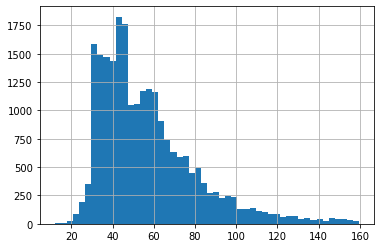

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64


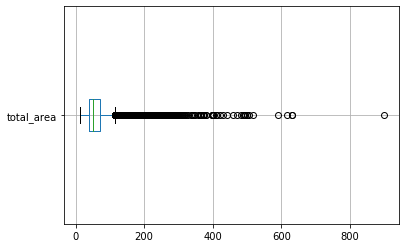

In [12]:
def plot_hist(data):
    data = data.dropna()
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    data.hist(bins=50, range=(data.min(), Q3 + 3 * IQR))
    plt.show()
    print(data.describe())
    
plot_hist(real_estate_data['total_area'])

real_estate_data.boxplot('total_area', vert=False)

+ Пик приходится на квартиры с площадью 30-50 $м^2$. Диапазон построения гистограммы выбран для удобства восприятия, квартир с площадью более 400 $м^2$ всего 23 штуки и на графике просто не видны.

+ По диаграмме размахе видно наличие квартир с очень большой плащадью будет сильно влиять на наш последующий анализ, такие значения являются выбросами. Отсечём квартиры площадь которых превышает Q3 + 1.5*IQR.

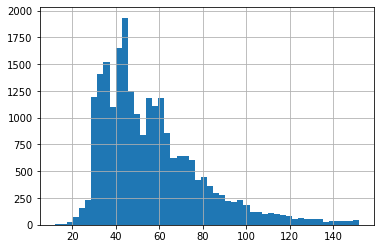

count    23229.000000
mean        56.948898
std         23.739701
min         12.000000
25%         40.000000
50%         51.200000
75%         68.000000
max        159.300000
Name: total_area, dtype: float64


In [13]:
def delete_outliers(df, column):
    df[column].dropna()
    Q1 = np.percentile(df[column], 25)
    Q3 = np.percentile(df[column], 75)
    IQR = Q3 - Q1
    df.loc[df[column] > (Q3 + 3 * IQR), column] = pd.np.nan

#real_estate_data.loc[real_estate_data['total_area'] > np.percentile(real_estate_data['total_area'], 99), 'total_area'] = pd.np.nan
delete_outliers(real_estate_data, 'total_area')
plot_hist(real_estate_data['total_area'])

##### Стоимость квартир
Для удобства представим цены в миллионах рублей

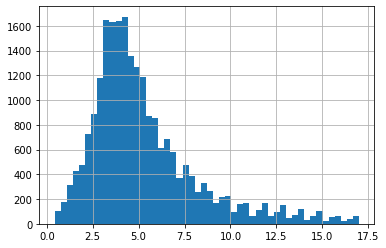

count    23699.000000
mean         6.542063
std         10.886992
min          0.430000
25%          3.400000
50%          4.650000
75%          6.800000
max        763.000000
Name: last_price, dtype: float64


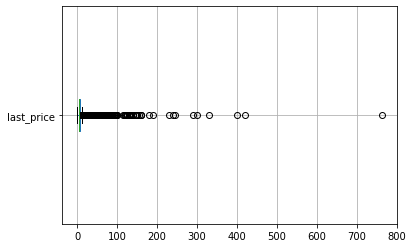

In [14]:
real_estate_data['last_price'] = real_estate_data['last_price'] / (10 ** 6)

plot_hist(real_estate_data['last_price'])

real_estate_data.boxplot('last_price', vert=False)

+ Пик приходится на квартиры стоимостью 3-4.5 млн рублей.

+ Для отсечения выбросов также используем диаграмму размаха.

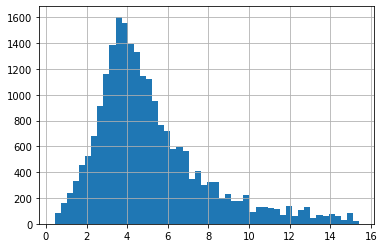

count    22756.000000
mean         5.287636
std          2.941847
min          0.430000
25%          3.393697
50%          4.500000
75%          6.400000
max         17.000000
Name: last_price, dtype: float64


In [15]:
delete_outliers(real_estate_data, 'last_price')
plot_hist(real_estate_data['last_price'])

##### Количество комнат

count    23699.000000
mean         2.079708
std          1.066575
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

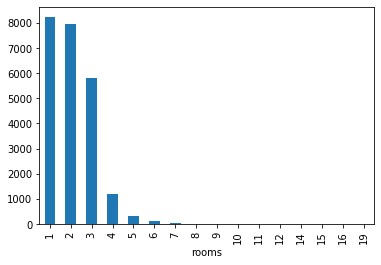

In [16]:
rooms_data = real_estate_data.groupby('rooms')['rooms'].agg('count')
rooms_data.plot(kind='bar')
real_estate_data['rooms'].describe()

##### Высота потолков

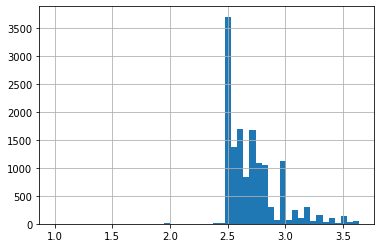

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64


In [17]:
plot_hist(real_estate_data['ceiling_height'])

+ Присутствуют слишком маленькие значения, менее 2,4м (21шт). Значения некорректные поскольку в России высота потолков не должна быть менее 2.5м (СНиП 31-01-2003, 5.8), однако не исключены небольшие погрешности, поэтому выбрал 2.4м как пороговое значение.
+ Присутствуют слишком большие значения, более 10,3м (24шт). Считаю значения ошибочными, поскольку в интернете смог найти квартиры с максимальной высотой потолков в 10.3м


Избавимся от этих значений

In [18]:
real_estate_data.loc[real_estate_data['ceiling_height'] < 2.4, 'ceiling_height'] = pd.np.nan
real_estate_data.loc[real_estate_data['ceiling_height'] > 10.3, 'ceiling_height'] = pd.np.nan

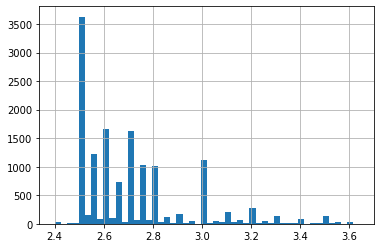

count    14459.000000
mean         2.729565
std          0.298540
min          2.400000
25%          2.520000
50%          2.650000
75%          2.800000
max         10.300000
Name: ceiling_height, dtype: float64


In [19]:
plot_hist(real_estate_data['ceiling_height'])

+ Наибольшее количество квартир имеет высоту потолков около 2,5м - стандартная высота в хрущёвках.
+ Также хорошо выделяются два локальных пика: 2,7м и 3м.
+ Пики соответствуют наиболее типичным значениям высоты потолков

##### Время продажи квартир

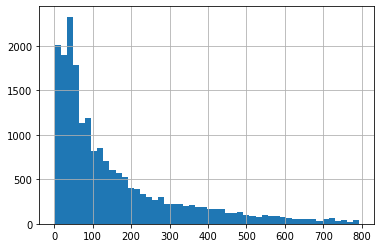

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64


In [20]:
plot_hist(real_estate_data['days_exposition'])

+ В среднем квартиры продаются в течение 181 дня, половина продаж происходит в течении 95 дней. Такое сильное смещение среднего вызвано относительно небольшим количеством случаев с длительным сроком продаж.
+ Гистограмма довольно плавная, определить по ней быстрые и долгие продажи проблематично. Можно условно принять за границы значения 1-го квартиля для быстрых продаж (45 дней) и 3-го - для долгих (232).

##### Исследование факторов, влияющих на стоимость квартир

,last_price,total_area,rooms,city_centers_nearest
last_price,1.000000,0.758239,0.504653,-0.357298
total_area,0.758239,1.000000,0.788591,-0.231210
rooms,0.504653,0.788591,1.000000,-0.187704
city_centers_nearest,-0.357298,-0.231210,-0.187704,1.000000


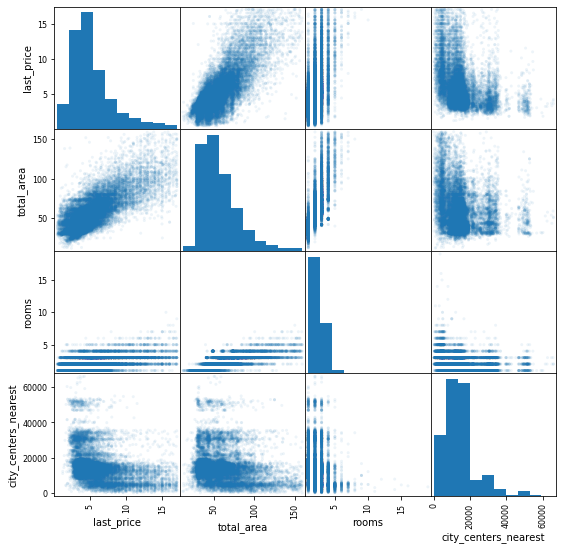

In [21]:
research_data = real_estate_data.loc[:, ['last_price', 'total_area', 'rooms', 'city_centers_nearest']]
pd.plotting.scatter_matrix(research_data, figsize=(9, 9), alpha=0.08);
research_data.corr()

##### Цена - Общая площадь
+ Очевидная взаимосвязь. Чем больше квартира, тем она дороже.

##### Цена - Количество комнат
+ В общем случае чем больше комнат, тем больше площадь квартиры, а значит и её стоимость.

##### Цена - Удалённость от центра
+ В этом случае прослеживается тренд на уменьшение стоимости квартиры с увеличением расстояния до центра (похоже на экспоненциальное убывание цены). Однако близко к центру всё-равно имеется недорогое жильё


Мы можем наблюдать общие тренды, но хорошо прослеживаемой зависимости нет потому что на стоимость квартиры может влиять множество других факторов: год постройки дома, тип дома, элитность дома, наличие и качество ремонта, вид из окна и т.д. и т.п.  
Дополнительные шумы возникают из-за того, что рассматриваются квартир из разных населённых пунктов, где заведомо разный уровень цен.

##### Общая площадь - Цена р/$м^2$

Зависимость цены квартиры от её площади вещь слишком очевидная. Справедливости ради попробуем рассмотреть более "справедливый" показатель - цену 1-го квадратного метра.

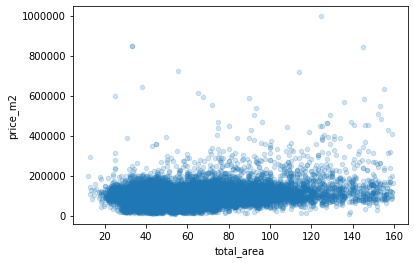

In [22]:
real_estate_data.plot.scatter(x='total_area', y='price_m2', alpha=0.2)

+ Как видим удельная стоимость вещь довольно однородная и больше зависит от факторов по которым у нас нет данных
+ Ожидалось увидеть, что чем больше квартира, тем меньше в ней цена за 1$м^2$ (из разряда оптом дешевле). Гипотеза не подтвердилась

##### Этаж

Этаж другой
Количество квартир: 16731
Среднее: 5.51млн р, Медиана: 4.70млн р 

Этаж первый
Количество квартир: 2863
Среднее: 4.32млн р, Медиана: 3.88млн р 

Этаж последний
Количество квартир: 3162
Среднее: 5.00млн р, Медиана: 4.20млн р 



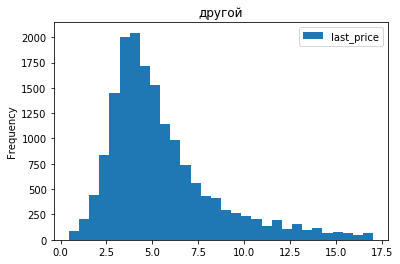

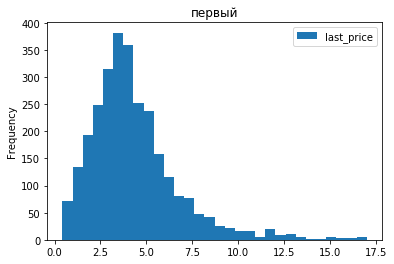

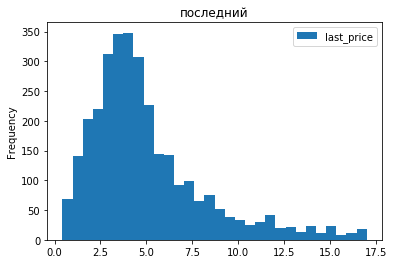

In [23]:
for name, group_data in real_estate_data.groupby('floor_category'):
    print('Этаж', name)
    print('Количество квартир:', format(group_data['last_price'].count()))
    print('Среднее: {:.2f}млн р, Медиана: {:.2f}млн р \n'.format(group_data['last_price'].mean(), group_data['last_price'].median()))
    group_data.plot(kind='hist', y='last_price', title=name, bins=30)

+ Характер распределения для всех групп схож: на любом этаже есть как дорогие, так и дешёвые квартиры.
+ В общем случае квартиры на первом и последнем этажах несколько дешевле остальных.

##### День недели, месяц, год

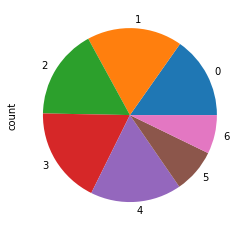

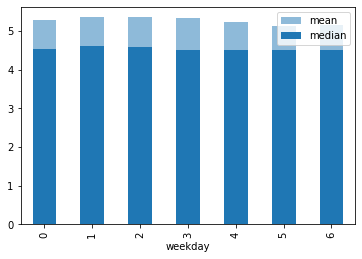

In [24]:
def date_plot(df, column, date):
    date_data = df.pivot_table(index=date, values=column, aggfunc=['count','mean' ,'median' ])
    date_data.columns = ['count', 'mean', 'median']
    date_data['count'].plot(kind='pie')
    plt.show()
    date_data['mean'].plot(kind='bar', alpha=0.5, legend=True)
    date_data['median'].plot(kind='bar', legend=True)

date_plot(real_estate_data, 'last_price', 'weekday')

+ День недели никоим образом не влияет на стоимость квартиры. Медианные и средние значения практически одинаковы для любого дня
+ Количество размещаемых объявлений втечении будних дней одинаково, в субботу и воскресенье заметно меньше - выходные всё-так.

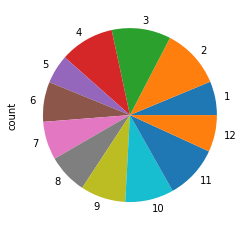

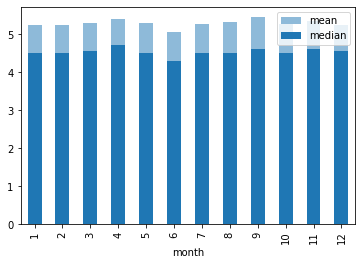

In [25]:
date_plot(real_estate_data, 'last_price', 'month')

+ Заметной зависимости не наблюдается.

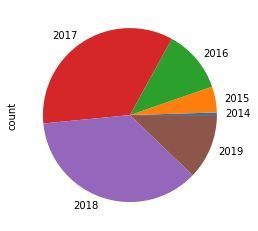

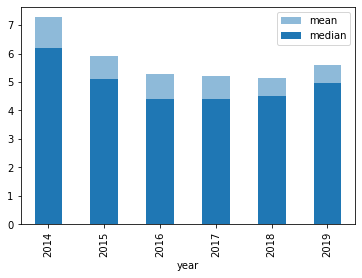

In [26]:
date_plot(real_estate_data, 'last_price', 'year')

+ В 2014 году в России произошёл кризис, приведший к снижению реальных доходов населения (соответственно понизился и спрос), что повлекло за собой и коррекционное снижение цен (лучше продать подешевле, чем вообще не продать). К 2019 году реальные доходы расти не стали, но ключевая ставка ЦБ РФ была понижена ниже 8% (действия государства с целью стимулирования экономики), из-за чего ипотечные кредиты стали более доступны, спрос на квартиры повысился и цены начали расти.

#### Топ-10 городов по количеству объявлений

In [27]:
def rename(locality):
    try:
        new_name = ' '.join(re.findall('([А-Я][а-я]+)', locality))
        return new_name
    except:
        return pd.np.nan
    
real_estate_data['new_name'] = real_estate_data['locality_name'].apply(rename)

real_estate_data['new_name'].value_counts().head(10)

Санкт Петербург    15721
Мурино               590
Кудрово              472
Шушары               440
Всеволожск           398
Пушкин               369
Колпино              338
Парголово            327
Гатчина              307
Выборг               237
Name: new_name, dtype: int64

In [28]:
cities_top_list = ['Санкт Петербург', 'Мурино',
                   'Кудрово', 'Шушары',
                   'Всеволожск', 'Пушкин',
                   'Колпино', 'Парголово',
                   'Гатчина', 'Выборг']
cities_top_data = real_estate_data.query('new_name in @cities_top_list').pivot_table(index='new_name', values='last_price')
cities_top_data.sort_values(by='last_price', ascending=False)

,last_price
new_name,
Санкт Петербург,6.260459
Пушкин,5.899603
Парголово,4.488075
Кудрово,4.358688
Шушары,4.108082
Колпино,3.866289
Всеволожск,3.737119
Мурино,3.678462
Гатчина,3.488337


+ Самое дорогое жильё находится в Санкт-Петербурге. Санкт-Петербург второй по численности город в РФ и второй по экономическим показателям, что и обуславливает высокую стоимоть жилья.
+ Самое дешёвое жильё в Выборге. Из 10 приведённых населённых пунктов Выборг расположен дальше всех от Санкт-Петербурга.

#### Санкт-Петербург

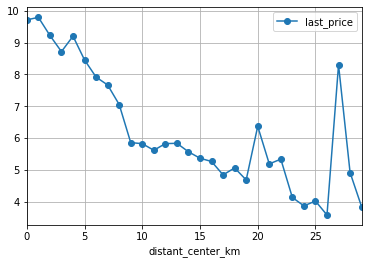

In [29]:
import math
spb_data = real_estate_data.query('locality_name == "Санкт-Петербург"')
spb_data = spb_data.dropna(subset=['city_centers_nearest'])
spb_data['distant_center_km'] = (spb_data['city_centers_nearest'] / 1000).apply(math.floor)
spb_data.pivot_table(index='distant_center_km', values='last_price').plot(grid=True, marker='o')

+ Построен график зависимости средней цены квартиры от расстояния до центра. Для наглядности расстояние представлено в километрах, округление производилось до ближайшего целого в меньшую сторону, таким образом каждая точка на графике представляет собой среднюю стоимость квартир, расположенных в интервале от n до n+1 км.
+ Можно выделить центральную зону в радиусе 9 километров от центра, поскольку после 9-го километра резко уменьшается средняя стоимость квартир.

#### Центр Санкт-Петербурга

##### Общая площадь

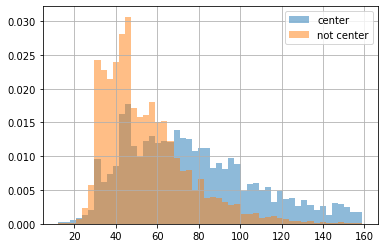

Центр города:
 count    4023.000000
mean       75.868158
std        30.929664
min        12.000000
25%        51.000000
50%        71.000000
75%        95.300000
max       159.000000
Name: total_area, dtype: float64

Остальная часть города:
 count    11206.000000
mean        54.296046
std         20.641096
min         13.000000
25%         39.200000
50%         49.200000
75%         64.000000
max        159.300000
Name: total_area, dtype: float64


In [30]:
spb_center_data = spb_data.query('city_centers_nearest < 9000')
spb_outer_data = spb_data.query('city_centers_nearest >= 9000')

def compare_plot(data1, data2):
    data1.hist(bins=50, density=True, alpha=0.5, label='center', range=(data1.min(), data1.max()))
    data2.hist(bins=50, density=True, alpha=0.5, label='not center', range=(data1.min(), data1.max()))
    plt.legend(loc='upper right')
    plt.show()
    print('Центр города:\n', data1.describe())
    print()
    print('Остальная часть города:\n', data2.describe())
    
compare_plot(spb_center_data['total_area'], spb_outer_data['total_area'])

+ Распределения по площади боле равномерное.
+ Квартиры в центре имеют большу площадь, среднее - 75,$м^2$ против 54,29.

##### Стоимость квартир

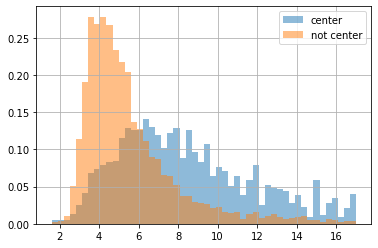

Центр города:
 count    3646.000000
mean        8.413014
std         3.390084
min         1.600000
25%         5.811250
50%         7.813900
75%        10.515723
max        17.000000
Name: last_price, dtype: float64

Остальная часть города:
 count    11112.000000
mean         5.549686
std          2.426027
min          1.190000
25%          3.950000
50%          4.890000
75%          6.391250
max         17.000000
Name: last_price, dtype: float64


In [31]:
compare_plot(spb_center_data['last_price'], spb_outer_data['last_price'])

+ Квартиры в центре заметно дороже.

##### Количество комнат

count    4382.000000
mean        2.729804
std         1.402063
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max        19.000000
Name: rooms, dtype: float64

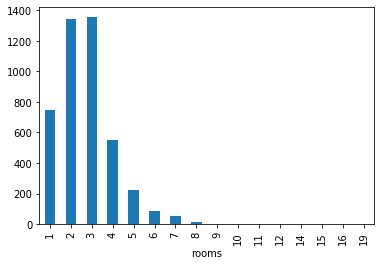

In [32]:
spb_center_rooms_data = spb_center_data.groupby('rooms')['rooms'].agg('count')
spb_center_rooms_data.plot(kind='bar')
spb_center_data['rooms'].describe()

+ Преобладают квартиры с 2-3 комнатами

##### Высота потолков

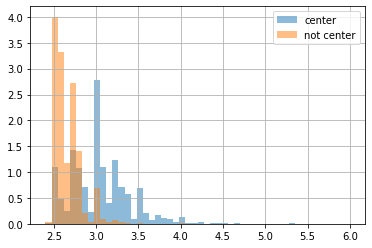

Центр города:
 count    2861.000000
mean        3.043418
std         0.374671
min         2.400000
25%         2.800000
50%         3.000000
75%         3.200000
max         6.000000
Name: ceiling_height, dtype: float64

Остальная часть города:
 count    7193.000000
mean        2.655067
std         0.209086
min         2.400000
25%         2.500000
50%         2.600000
75%         2.750000
max        10.300000
Name: ceiling_height, dtype: float64


In [33]:
compare_plot(spb_center_data['ceiling_height'], spb_outer_data['ceiling_height'])

+ Имеется явный пик на 3м. Думаю это связано с тем, что Петербург город старый и в советское время не было возможности всё застроить хрущёвками.

##### Время продажи квартир

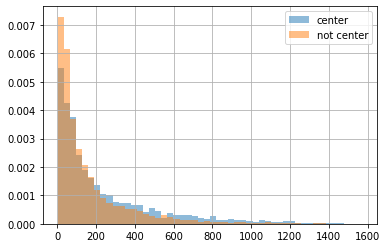

Центр города:
 count    3675.000000
mean      237.781769
std       270.212217
min         3.000000
25%        57.000000
50%       130.000000
75%       329.000000
max      1572.000000
Name: days_exposition, dtype: float64

Остальная часть города:
 count    9938.000000
mean      162.520427
std       201.738226
min         1.000000
25%        39.000000
50%        87.000000
75%       202.000000
max      1553.000000
Name: days_exposition, dtype: float64


In [34]:
compare_plot(spb_center_data['days_exposition'], spb_outer_data['days_exposition'])

+ Средняя и медианная длительность продажи квартир выше, чем по всем данным. Обусловлено более высокими ценами на квартиры.

,last_price,total_area,rooms,city_centers_nearest
last_price,1.000000,0.758239,0.504653,-0.357298
total_area,0.758239,1.000000,0.788591,-0.231210
rooms,0.504653,0.788591,1.000000,-0.187704
city_centers_nearest,-0.357298,-0.231210,-0.187704,1.000000


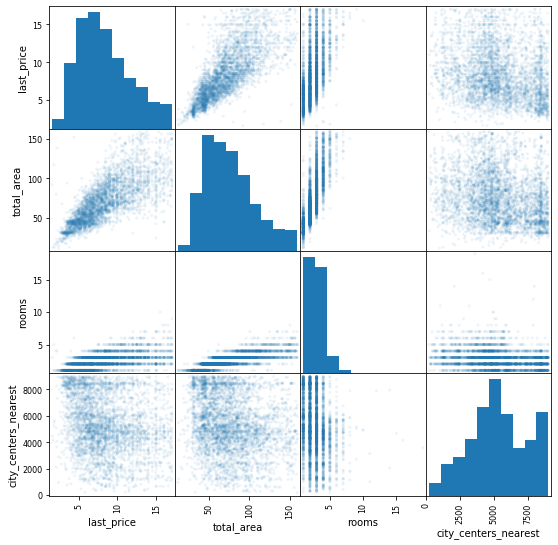

In [35]:
spb_center_research_data = spb_center_data.loc[:, ['last_price', 'total_area', 'rooms', 'city_centers_nearest']]
pd.plotting.scatter_matrix(spb_center_research_data, figsize=(9, 9), alpha=0.08);
research_data.corr()

+ Зависимость цены от площади и количества комнат такая же как и в случае со всеми данными.
+ В центральной части города удалённость от центра не влияет на стоимость квартир.

##### Зависимость цены от этажа

In [36]:
spb_center_data.pivot_table(index='floor_category', values='last_price', aggfunc=['mean', 'median'])

,mean,median
,last_price,last_price
floor_category,,
другой,8.663460,8.1
первый,6.729178,6.1
последний,8.533617,8.0


+ Квартиры на первом этаже заметно дешевле других.
+ Разница в стоимости квартир на последнем этаже и других уже не так ощутима.

##### Год продажи

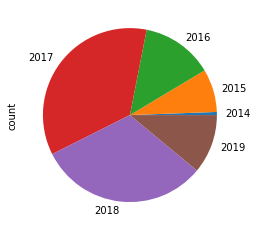

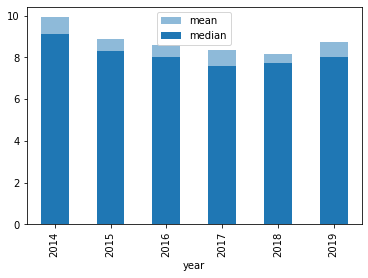

In [37]:
date_plot(spb_center_data, 'last_price', 'year')

+ Экономическая ситуация в стране влияет на всё без исключения. Квартиры в центре подвержены тем же изменеиям, что и любые другие.

### Шаг 5. Общий вывод

+ Факторы сильнее всего, влияющие на стоимость квартир:
    + город, в котором расположена квартира - в крупных и более экономически развитых городах цены выше;
    + удалённость от центра - в городах есть центральная часть некоторого радиуса, в пределах которой квартиры значительно дороже.
    
    
+ Другие факторы:
    + общая площадь - чем больше площадь, тем больше цена;
    + этаж на котором расположена квартира - квартиры на первом этаже обычно дешевле квартир на последнем этаже, которые дешевле квартир, расположенных на других этажах.